 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [78]:
# Imports 
from importlib import reload
import utils; reload(utils); from utils import *
import data_generator; reload(data_generator); from data_generator import *
import models; reload(models); from models import *

In [2]:
# Limit Tensorflow GPU memory usage. 
# Note that it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
# Plotting setup
%matplotlib inline
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

In [4]:
# Define data paths
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/Mikes_inout/' # Full dataset
%ls $data_dir

SPCAM_mean_detailed.nc              SPCAM_outputs_valid_by_lon_flat.nc
SPCAM_outputs_detailed.nc           SPCAM_std_detailed.nc
SPCAM_outputs_train_by_lon_flat.nc


In [14]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
    'QRL': 2,
    'QRS': 2,
    'PRECT': 1,
    'FLUT': 1,
})

In [79]:
# Load the dataset
train_set_lon = DataSet(data_dir, 'SPCAM_outputs_train_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys(), target_norm=True,
                        target_norm_lev_weight=True)
valid_set_lon = DataSet(data_dir, 'SPCAM_outputs_valid_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys(), target_norm=True,
                        target_norm_lev_weight=True)

In [86]:
train_set_lon.targets.shape, train_set_lon.features.shape

((3681792, 86), (3681792, 86))

In [81]:
model = fc_model(train_set_lon.features.shape[1], train_set_lon.targets.shape[1], [512, 512], 
                 0.0001, 'mae')

In [82]:
model.fit(train_set_lon.features, train_set_lon.targets, batch_size=512, epochs=3, 
          validation_data=(valid_set_lon.features, valid_set_lon.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/3
3681792/3681792 [==============================] - 46s - loss: 0.0248 - rmse: 0.0540 - log_loss: -1.3953 - total_error: 1128.7456 - unexplained_error: 278.4151 - rsquared: 0.7522 - total_error_avgAx0: 1126.5906 - rsquared_avgAx0: 0.7517 - val_loss: 0.0204 - val_rmse: 0.0439 - val_log_loss: -1.4731 - val_total_error: 1089.4626 - val_unexplained_error: 174.0569 - val_rsquared: 0.8377 - val_total_error_avgAx0: 963.6871 - val_rsquared_avgAx0: 0.7995
Epoch 2/3
3681792/3681792 [==============================] - 46s - loss: 0.0196 - rmse: 0.0421 - log_loss: -1.4913 - total_error: 1128.7454 - unexplained_error: 161.1247 - rsquared: 0.8563 - total_error_avgAx0: 1126.6251 - rsquared_avgAx0: 0.8560 - val_loss: 0.0195 - val_rmse: 0.0417 - val_log_loss: -1.4997 - val_total_error: 1089.4626 - val_unexplained_error: 160.6279 - val_rsquared: 0.8534 - val_total_error_avgAx0: 963.6871 - val_rsquared_avgAx0: 0.8205
Epoch 3/3
3681792/3681792 [

In [83]:
preds = model.predict(valid_set_lon.features, batch_size=512)

<function matplotlib.pyplot.show>

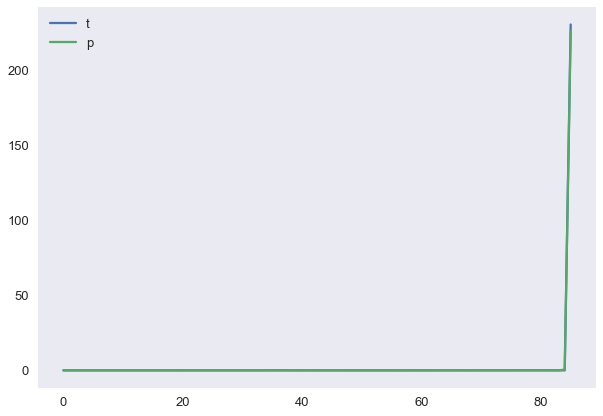

In [84]:
plt.plot(valid_set_lon.renorm_outputs(valid_set_lon.targets[0]), label='t')
plt.plot(valid_set_lon.renorm_outputs(preds[0]), label='p')
plt.legend(); plt.show

<function matplotlib.pyplot.show>

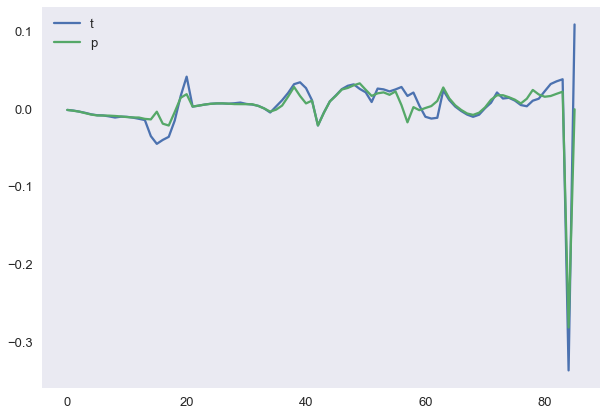

In [85]:
plt.plot(valid_set_lon.targets[0], label='t')
plt.plot(preds[0], label='p')
plt.legend(); plt.show